Visualize detector 3d bb (in 2d) on nuscenes with dataset_dict 

In [1]:
import sys
from PIL import Image
import pickle
sys.path.append('/home/dimitris/PhD/PhD/visualDet3D')
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
#from visualDet3D.visualDet3D.data.kitti.dataset import *
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer
from numba import jit
from tqdm import tqdm
print('CUDA available: {}'.format(torch.cuda.is_available()))

# cfg = cfg_from_file('/home/dimitris/PhD/PhD/visualDet3D/config/config.py')
cfg = cfg_from_file('/home/dimitris/PhD/PhD/PIFu/PIFu_config.py')
# is_test_train = True

checkpoint_name = '/home/dimitris/PhD/PhD/visualDet3D/workdirs/Mono3D/checkpoint/GroundAware_pretrained.pth'
# checkpoint_name = '/home/dimitris/PhD/PhD/visualDet3D/workdirs/Mono3D/checkpoint/GroundAwareYolo3D_latest.pth'


CUDA available: True


In [2]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
{'calib': array([[720.45067551,   0.        , 464.3652379 ,   0.        ],
       [  0.        , 720.45067551, 279.61290854,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]]), 'image': array([[[ 0.83042276,  0.8147365 ,  0.9245404 ],
        [ 0.8393433 ,  0.82365704,  0.93346095],
        [ 0.8531333 ,  0.83744705,  0.9472511 ],
        ...,
        [ 0.09299159,  0.09786129,  0.13220727],
        [ 0.08209896,  0.11347151,  0.12131464],
        [ 0.03959846,  0.07097101,  0.07881415]],

       [[ 0.84313726,  0.827451  ,  0.9372549 ],
        [ 0.8509854 ,  0.83529913,  0.94510305],
        [ 0.8587116 ,  0.8430253 ,  0.95282924],
        ...,
        [ 0.9768894 ,  0.97378385,  0.99713075],
        [ 0.9730778 ,  0.9798486 ,  0.9955349 ],
        [ 0.9226719 ,  0.92944276,  0.94512904]],

       [[ 0.8317653 ,  0.816079  ,  0.92588294],
        [ 0.8371986 ,  0.82151234,  0.93131626],
        [ 0.85098875,  0.8353025 ,  0.9451064 ],
     

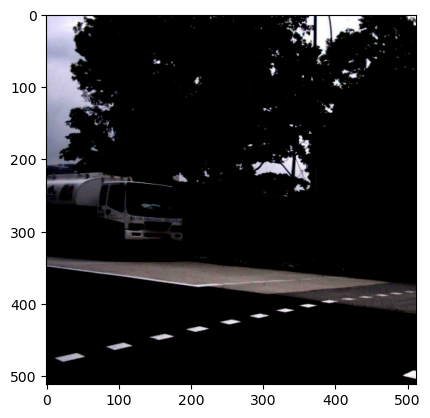

In [5]:
cfg.batch_size=1
split_to_test='training'

# is_test_train = split_to_test == 'training'
# print(is_test_train)

if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset
#val
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )
# print(dataset)
# if split_to_test=='training':
#     dataset_val = DATASET_DICT[cfg.data.val_dataset](
#             cfg, 'validation'
#             )
#     dataset.transform = dataset_val.transform
#     dataset.collate_fn = dataset_val.collate_fn

detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()
data = dataset[0]
im = data['image']
plt.imshow(im)
print(dataset.transform)
print(data['image'].shape)
print(data)
# print(data['ground-truth euler angle of 3dbb'])
# print(test_func)

In [4]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image


In [5]:
def compute_iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    
    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    
    if union_area == 0:
        return 0  # Avoid division by zero
    
    return intersection_area / union_area

def associate_boxes(predicted_bboxes, ground_truth_bboxes):
    associations = []
    for predicted in predicted_bboxes:
        best_iou = 0
        best_gt_idx = -1
        
        for idx, gt in enumerate(ground_truth_bboxes):
            iou_value = compute_iou(predicted[:4], gt) # using only the x1, y1, x2, y2 values
            if iou_value > best_iou:
                best_iou = iou_value
                best_gt_idx = idx
        
        # If the best_iou is above a certain threshold, say 0.5, then associate
        if best_iou > 0.5:
            associations.append((predicted[:4], ground_truth_bboxes[best_gt_idx], best_iou, best_gt_idx))
        else:
            associations.append((predicted[:4], None, best_iou, None))  # No association found
    
    return associations

In [6]:
from visualDet3D.data.pipeline import build_augmentator
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
    data = dataset[index]
    # print(data)
    # print(data['calib'])
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    collated_data = dataset.collate_fn([data])
    print(collated_data)
    transformed_image = collated_data[0]
    transformed_P2 = collated_data[1]   
    # print(transformed_P2)
    test_func = PIPELINE_DICT[cfg.trainer.test_func]
    with torch.no_grad():
        scores, bbox, obj_names = test_func(collated_data, detector, None, cfg=cfg)
        # print(f"bbox {bbox}")
        # print(f"data bbox2d {data['bbox2d']}")
        transformed_P2 = transformed_P2[0] 
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, transformed_P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, transformed_P2.cuda())
          
    rgb_image = denorm(transformed_image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    # Call it once to compute all the associations
    predicted_bboxes = bbox.cpu().numpy()
    ground_truth_bboxes = data['bbox2d']
    associations = associate_boxes(predicted_bboxes, ground_truth_bboxes)

    objects = []
    N = len(bbox)
    for i in range(N):
        obj = {}
        assoc = associations[i]
        if assoc[3] is not None:  # Check if index exists
            # print(assoc[3])
            obj['ground_truth_object_pose'] = data['ground-truth euler angle of 3dbb'][assoc[3]]
        else:
            obj['ground_truth_object_pose'] = None

        obj['whl'] = bbox_3d_state_3d[i, 3:6]
        obj['theta'] = thetas[i]
        obj['score'] = scores[i]
        obj['type_name'] = obj_names[i]
        obj['xyz'] = bbox_3d_state_3d[i, 0:3]
        objects.append(obj)
    print(objects)  

    """
    pickle data for 3d visualization
    """
    # Extract the values from the dictionaries
    data = []
    for obj in objects:
        xyz = obj['xyz'].cpu().numpy()
        whl = obj['whl'].cpu().numpy()
        theta = obj['theta'].cpu().numpy().reshape(1)  # Reshape theta to have one dimension
        entry = np.concatenate((xyz, whl, theta))
        data.append(entry)

    # Convert the list to a NumPy array
    data_array = np.array(data)
    # print(data_array)

    # Save the NumPy array as a pickle file
    with open('3d_bb_theta_correct.pkl', 'wb') as file:
        pickle.dump(data_array, file)

    return np.clip(rgb_image, 0, 255)

/home/dimitris/PhD/PhD/visualDet3D/visualDet3D/data/kitti/dataset/mono_dataset.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/torch/csrc/utils/tensor_new.cpp:245.)
  return torch.from_numpy(rgb_images).float(), torch.tensor(calib).float(), label, bbox2ds, bbox3ds


(tensor([[[[-1.3501, -1.3777, -1.3679,  ..., -1.2978, -1.3035, -1.3284],
          [-1.3911, -1.4215, -1.4519,  ..., -1.3186, -1.3501, -1.3478],
          [-1.3370, -1.4358, -1.4509,  ..., -1.3504, -1.3303, -1.2855],
          ...,
          [-1.3915, -1.0928, -1.1187,  ..., -0.9328, -0.9515, -0.9693],
          [-1.5899, -1.2731, -1.3197,  ..., -0.8829, -0.9030, -0.9358],
          [-1.6850, -1.3539, -1.4006,  ..., -0.9125, -0.9192, -0.9105]],

         [[-1.1633, -1.1915, -1.1814,  ..., -1.1272, -1.1331, -1.1586],
          [-1.2080, -1.2391, -1.2703,  ..., -1.1514, -1.1837, -1.1813],
          [-1.1674, -1.2683, -1.2838,  ..., -1.1986, -1.1780, -1.1322],
          ...,
          [-1.2513, -0.9459, -0.9752,  ..., -0.6841, -0.7032, -0.7214],
          [-1.3384, -1.0145, -1.1117,  ..., -0.6330, -0.6536, -0.6872],
          [-1.4356, -1.0971, -1.1944,  ..., -0.6634, -0.6702, -0.6613]],

         [[-1.0269, -1.0550, -1.0449,  ..., -0.8690, -0.8749, -0.9002],
          [-1.0414, -1.0724, 

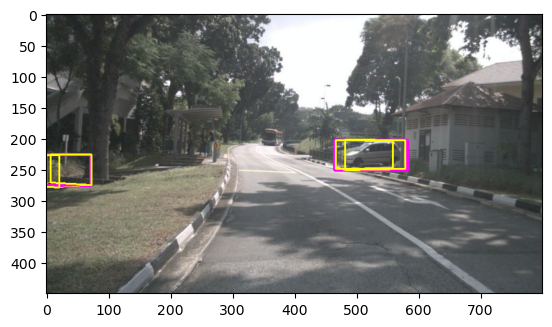

In [7]:
index = 0
a = compute_once(index)

(tensor([[[[-1.3501, -1.3777, -1.3679,  ..., -1.2978, -1.3035, -1.3284],
          [-1.3911, -1.4215, -1.4519,  ..., -1.3186, -1.3501, -1.3478],
          [-1.3370, -1.4358, -1.4509,  ..., -1.3504, -1.3303, -1.2855],
          ...,
          [-1.3915, -1.0928, -1.1187,  ..., -0.9328, -0.9515, -0.9693],
          [-1.5899, -1.2731, -1.3197,  ..., -0.8829, -0.9030, -0.9358],
          [-1.6850, -1.3539, -1.4006,  ..., -0.9125, -0.9192, -0.9105]],

         [[-1.1633, -1.1915, -1.1814,  ..., -1.1272, -1.1331, -1.1586],
          [-1.2080, -1.2391, -1.2703,  ..., -1.1514, -1.1837, -1.1813],
          [-1.1674, -1.2683, -1.2838,  ..., -1.1986, -1.1780, -1.1322],
          ...,
          [-1.2513, -0.9459, -0.9752,  ..., -0.6841, -0.7032, -0.7214],
          [-1.3384, -1.0145, -1.1117,  ..., -0.6330, -0.6536, -0.6872],
          [-1.4356, -1.0971, -1.1944,  ..., -0.6634, -0.6702, -0.6613]],

         [[-1.0269, -1.0550, -1.0449,  ..., -0.8690, -0.8749, -0.9002],
          [-1.0414, -1.0724, 

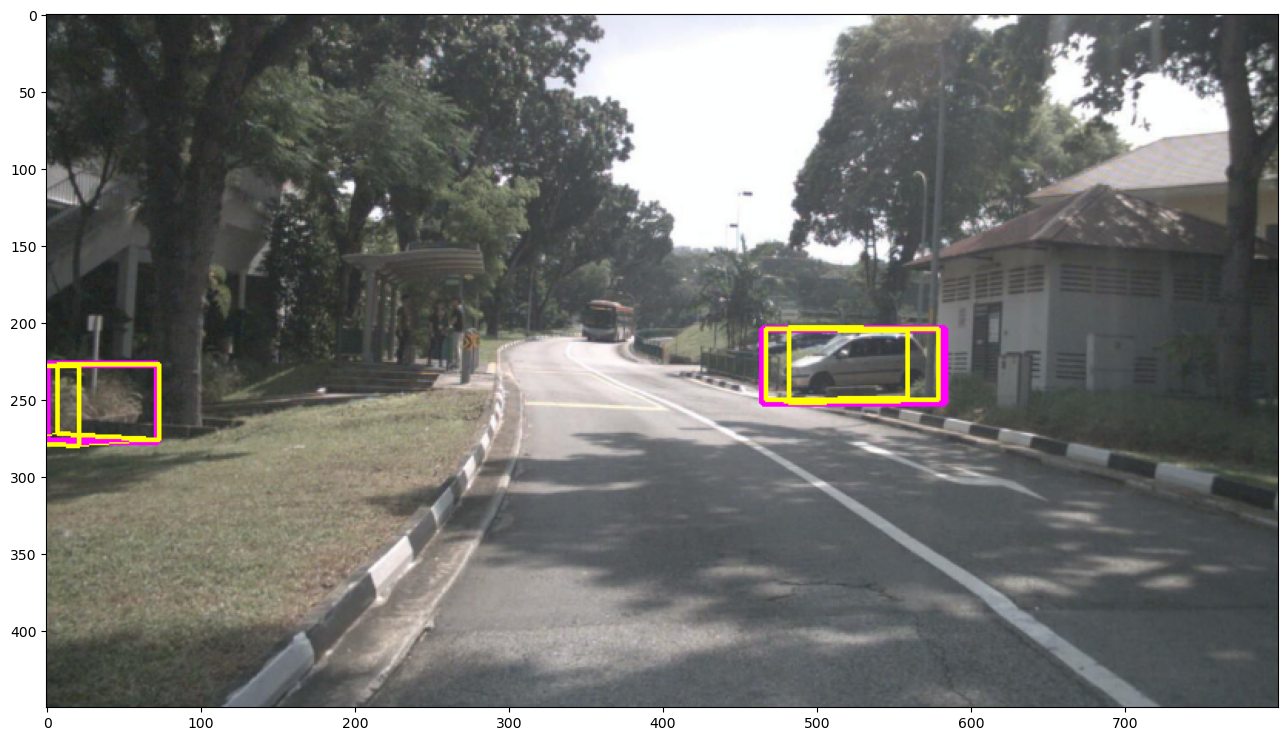

In [8]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
# index += 1
a = compute_once(index, is_test_train=False, is_draw=True)